In [16]:
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, ShuffleSplit, validation_curve
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from mlxtend.evaluate import bias_variance_decomp
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV ,cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score

In [2]:
def my_learn_curve(title="some title", 
                   estimator=None, 
                   cv = None ,
                   X=None,
                   y=None,
                   label_suffix =  None,
                   color_= [],
                   shape='o-'):
    plt.title(title)
    plt.ylim(0.0, 1.01)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=4,
                       train_sizes=np.linspace(.1, 1.0, 10),
                       return_times=True)
    train_scores_mean =  1.0 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean =  1.0 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)


    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes,  train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes,  test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, shape, color=color_[0],
                 label="Training Error - {}".format(label_suffix))
    plt.plot(train_sizes, test_scores_mean,shape, color=color_[1],
                 label="Cross-validation Error - {}".format(label_suffix))
    plt.legend(loc="best")
    plt.ylabel("Error")
    return plt

In [9]:
parent_dir = '/mnt/c/users/17752/Documents/GeorgiaTech/machine_learning'

# Liver Data 

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
liver_df = pd.read_csv(f"{parent_dir}/data/liver.csv")
liver_df = pd.read_csv(f"{parent_dir}/data/liver.csv")
liver_df.drop_duplicates(inplace=True)
impute_Albumin_and_Globulin_Ratio = liver_df[~liver_df.Albumin_and_Globulin_Ratio.isna()].Albumin_and_Globulin_Ratio.mean()
filt_ =  liver_df.Albumin_and_Globulin_Ratio.isna()
liver_df.loc[filt_, "Albumin_and_Globulin_Ratio" ]= impute_Albumin_and_Globulin_Ratio
assert sum(liver_df.Albumin_and_Globulin_Ratio.isna()) == 0 
# format response 
liver_df.loc[(liver_df.Dataset ==2), "Dataset" ] = 0
liver_df.head(10)
liver_df.loc[:,"Gender"] = pd.get_dummies(liver_df.Gender, prefix='gender').drop("gender_Male", axis =1  ).gender_Female
X = liver_df.loc[:, "Age":"Albumin_and_Globulin_Ratio"]
y = liver_df["Dataset"]

# get validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


#('over', SMOTE(sampling_strategy="minority")
#inital shot 
def get_liver_pipeline(iter_=1):
    liver_steps = [('scaler', MinMaxScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ , solver ="adam", momentum=False
                                             ))]

    return Pipeline(steps=liver_steps)

stratified_kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
val_train_scores = []
for i in range (1,100,1):
    scores = cross_validate(get_liver_pipeline(i), X_train, y_train, cv=stratified_kfold,
                   scoring=('accuracy'),
                    return_train_score=True)
    val = 1. - scores['test_score'].mean()
    training = 1. - scores['train_score'].mean()
    epoch = i
    val_train_scores.append([training,val,epoch])
    
pd_val = pd.DataFrame(val_train_scores, columns=["Training", "Cross_Validation","epoch"])
val_plot =pd_val.plot(y=["Training", "Cross_Validation"],x="epoch", title="MLP Learning Curve-SGD No Monentum" )
plt.ylim(0.0, 1.01)
plt.ylabel('Error')
plt.xlabel('Epoch')
   
    
#adaptive moment estimation

In [ ]:
my_learn_curve(title=" MLP ", 
               estimator=get_liver_pipeline(400), 
               cv=stratified_kfold, 
               X=X_train,
               y=y_train,
               label_suffix="Base MLP", 
               color_=["red","green"],
               shape = 'o-'  )

In [ ]:
plot_confusion_matrix(estimator= get_liver_pipeline(400).fit(X_train,y_train), X=X_test, y_true= y_test  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["Not Patient" ,"Patient"]
                        )

## Validation Curve

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
train_scores, valid_scores = validation_curve(get_liver_pipeline(50),
                                              X_train,
                                              y_train, 
                                              param_name =  "model__max_iter",
                                            param_range =[ i for i in range (1,600,40)] ,
                                            cv=cv)

param_range =   np.array([ i for i in range (1,600,40)] )
train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Complexity Curve")
plt.xlabel("Training Iterations")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")


plt.savefig("MLP_LIVER_MAX_ITER.pdf")

plt.show()

In [ ]:
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
train_scores, valid_scores = validation_curve(get_liver_pipeline(400),
                                              X_train,
                                              y_train, 
                                              param_name =  "model__alpha",
                                            param_range =np.linspace(0.0001,1.,10) ,
                                            cv=cv)

param_range =   np.linspace(0.0001,2.,10)
train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Complexity Curve MLP")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")


plt.savefig("MLP_LIVER_alpha_adam.pdf")

plt.show()

In [3]:
MLPClassifier?

In [4]:
get_liver_pipeline(50).get_params()

NameError: name 'get_liver_pipeline' is not defined

## Grid Search Liver 

In [ ]:
# Set the parameters by cross-validation



tuned_parameters = {'model__activation': ["logistic","tanh","relu"], 
                    'model__alpha': np.linspace(0.0001,.5,15),
                    "model__solver" : ["sgd","adam","lbfgs"],
                    "model__learning_rate": ["constant", "invscaling"] ,
                     "model__max_iter" : [ i for i in range(10,400,20)]}
                    


# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=45)
# define the grid search procedure
grid_search = GridSearchCV(estimator=get_liver_pipeline(1), param_grid=tuned_parameters, 
                           n_jobs=-1, cv=cv, 
                           scoring='average_precision')
# execute the grid search
grid_result_l = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f usin g %s" % (grid_result_l.best_score_, grid_result_l.best_params_))
# summarize all scores that were evaluated
means = grid_result_l.cv_results_['mean_test_score']
stds = grid_result_l.cv_results_['std_test_score']
params = grid_result_l.cv_results_['params']

In [ ]:
# Best: 0.906910 usin g {'model__activation': 'logistic', 'model__alpha': 0.035807142857142864, 'model__learning_rate': 'invscaling', 'model__max_iter': 70, 'model__solver': 'lbfgs'}

In [5]:
def get_liver_pipeline_final(iter_=70,):
    liver_steps = [('scaler', MinMaxScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ ,
                                             solver ="lbfgs",
                                             learning_rate = "invscaling",
                                             activation="logistic",
                                             alpha= 0.035807142857142864, 
                                             random_state = 12, 
                                             early_stopping=True
                                             
                                             ))]

    return Pipeline(steps=liver_steps)

In [6]:

my_learn_curve(title=" Support Vector Machine", 
               estimator=get_liver_pipeline_final(solver_="adam" ), 
               cv=stratified_kfold, 
               X=X_train,
               y=y_train,
               label_suffix="best-rbf", 
               color_=["red","green"],
               shape = 'o-'  )

# my_learn_curve(title=" Support Vector Machine", 
#                estimator=liver_pipeline_linear.fit(X_train,y_train), 
#                cv=stratified_kfold,
#                X=X_train,
#                y=y_train ,
#                label_suffix="rbf", 
#                color_=["orange","blue"], shape = 'x-' )

NameError: name 'get_liver_pipeline_final' is not defined

In [6]:
get_liver_pipeline_final().get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model',
   MLPClassifier(activation='logistic', alpha=0.035807142857142864,
                 early_stopping=True, learning_rate='invscaling', max_iter=70,
                 random_state=12, solver='lbfgs'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': MLPClassifier(activation='logistic', alpha=0.035807142857142864,
               early_stopping=True, learning_rate='invscaling', max_iter=70,
               random_state=12, solver='lbfgs'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__activation': 'logistic',
 'model__alpha': 0.035807142857142864,
 'model__batch_size': 'auto',
 'model__beta_1': 0.9,
 'model__beta_2': 0.999,
 'model__early_stopping': True,
 'model__epsilon': 1e-08,
 'model__hidden_layer_sizes': (100,),
 'model__learning_rate': 'invscaling',
 'model__learning_rate_init': 0.001,
 'model__max_fun': 15000,
 'model__max_iter': 70,
 'model__momentum': 0.9,
 'model__n_iter_no_change': 10

In [ ]:
stratified_kfold = StratifiedKFold(n_splits = 10, random_state=42, shuffle=True)
val_train_scores = []
for i in range (1,80,5):
    scores = cross_validate(get_liver_pipeline_final(i), X_train, y_train, cv=stratified_kfold,
                   scoring=('accuracy'),
                    return_train_score=True)
    val = 1. - scores['test_score'].mean()
    training = 1. - scores['train_score'].mean()
    epoch = i
    val_train_scores.append([training,val,epoch])
    
pd_val = pd.DataFrame(val_train_scores, columns=["Training", "Cross_Validation","epoch"])
val_plot =pd_val.plot(y=["Training", "Cross_Validation"],x="epoch", title="MLP Learning Curve-LBFGS" )
plt.ylim(0.0, 1.1)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig("MLP_FINAL_LIVER_LEARNING_CURVE.pdf")

In [ ]:
plot_confusion_matrix(estimator= get_liver_pipeline_final( ).fit(X_train,y_train), X=X_test, y_true= y_test  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["Not Patient" ,"Patient"]
                        )



In [24]:
def get_liver_pipeline_base():
    liver_steps = [('scaler', MinMaxScaler()),
                   ("model",   MLPClassifier(
                                             solver ="sgd",
                                             activation="logistic",
                                             random_state = 12
                                             ))]

    return Pipeline(steps=liver_steps)

0.7117181488738253

In [27]:
base = get_liver_pipeline_base()
print(average_precision_score(y_train, base.fit(X_train,y_train).predict_proba(X_train)[:,1]))
print(average_precision_score(y_train, final_liver.predict_proba(X_train)[:,1]))
print(average_precision_score(y_test, final_liver.predict_proba(X_test)[:,1]))

0.7117181488738253
0.910525480393755
0.8744202551854581


0.8744202551854581

In [15]:
final_liver = get_liver_pipeline_final().fit(X_train,y_train)
print(final_liver.get_params())
print(classification_report(y_train, final_liver.predict(X_train) ))
print(classification_report(y_test, final_liver.predict(X_test) ))

{'memory': None, 'steps': [('scaler', MinMaxScaler()), ('model', MLPClassifier(activation='logistic', alpha=0.035807142857142864,
              early_stopping=True, learning_rate='invscaling', max_iter=70,
              random_state=12, solver='lbfgs'))], 'verbose': False, 'scaler': MinMaxScaler(), 'model': MLPClassifier(activation='logistic', alpha=0.035807142857142864,
              early_stopping=True, learning_rate='invscaling', max_iter=70,
              random_state=12, solver='lbfgs'), 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'model__activation': 'logistic', 'model__alpha': 0.035807142857142864, 'model__batch_size': 'auto', 'model__beta_1': 0.9, 'model__beta_2': 0.999, 'model__early_stopping': True, 'model__epsilon': 1e-08, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'invscaling', 'model__learning_rate_init': 0.001, 'model__max_fun': 15000, 'model__max_iter': 70, 'model__momentum': 0.9, 'model__n_iter_no_change': 10, 'model__nesterovs_momentum': Tr

## Census Data 

In [33]:
census_df = pd.read_csv(f"{parent_dir}/data/adult.csv")
census_df.drop_duplicates(inplace=True)
# # Deleting duplicates 
census_df.duplicated().sum()
#Replacing '?' for nans
census_df = census_df.replace('?', np.NaN)
# Mapping already our target variable in  1 and 0.
census_df.income = census_df.income.map({'<=50K':0, '>50K':1})

train_data, test_data = train_test_split(census_df,
                                         test_size=0.2,
                                         stratify=census_df['income'],
                                         random_state=65)
print('Train data shape is {}'.format(train_data.shape))
print('Test data shape is {}'.format(test_data.shape))
X_c_train = train_data.drop('income', axis=1)
y_c_train = train_data['income']
X_c_test= test_data.drop('income', axis=1)
y_c_test= test_data['income']

#Transforming categorical columns
categorical_columns= X_c_train.select_dtypes(object).columns



def get_census_pipeline(iter_=1):
    liver_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('scaler', StandardScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ , solver ="adam"
                                             ))]
    return Pipeline(steps=liver_steps)



stratified_kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
val_train_scores = []
for i in range (1,200,25):
    scores = cross_validate(get_census_pipeline(i), X_c_train, y_c_train, cv=stratified_kfold,
                   scoring=('accuracy'),
                    return_train_score=True)
    val = 1. - scores['test_score'].mean()
    training = 1. - scores['train_score'].mean()
    epoch = i
    val_train_scores.append([training,val,epoch])
    
pd_val = pd.DataFrame(val_train_scores, columns=["Training", "Cross_Validation","epoch"])
val_plot =pd_val.plot(y=["Training", "Cross_Validation"],x="epoch", title="MLP Learning Curve-SGD No Monentum" )
plt.ylim(0.0, 1.01)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig("MLP_BASE_CENSUS_LEARNING_CURVE_SGD.pdf")

Train data shape is (26029, 15)
Test data shape is (6508, 15)


In [12]:
def get_census_pipeline(iter_=1):
    liver_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('scaler', StandardScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ , solver ="adam"
                                             ))]
    return Pipeline(steps=liver_steps)

<module 'matplotlib.pyplot' from '/home/flufylobster/anaconda3/envs/ML39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

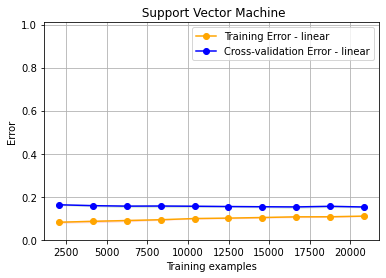

In [13]:

my_learn_curve(title=" Support Vector Machine", 
               estimator=get_census_pipeline(50), 
               cv=stratified_kfold,
               X=X_c_train, 
               y=y_c_train,  
               label_suffix="linear", 
               color_=["orange","blue"],
               shape = 'o-'  )


# my_learn_curve(title=" Support Vector Machine", 
#                estimator=census_pipeline_rbf, 
#                cv=stratified_kfold,
#                X=X_c_train, 
#                y=y_c_train,  
#                label_suffix="rbf", 
#                color_=["orange","blue"],
#                shape = 'x-'  )



In [ ]:
plot_confusion_matrix(estimator= census_pipeline_rbf.fit(X_c_train,y_c_train),
                      X=X_c_train,
                      y_true= y_c_train  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["Not Patient" ,"Patient"]
                        )

In [ ]:
plot_confusion_matrix(estimator= census_pipeline_linear.fit(X_c_train,y_c_train),
                      X=X_c_train,
                      y_true= y_c_train  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["Not Patient" ,"Patient"]
                        )

## Complexity 


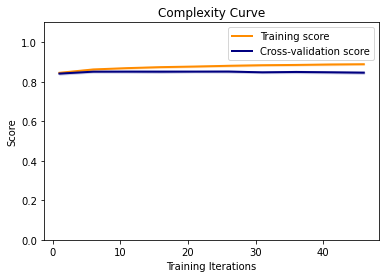

In [18]:
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
train_scores, valid_scores = validation_curve(get_census_pipeline(1),
                                              X_c_train,
                                              y_c_train, 
                                              param_name =  "model__max_iter",
                                            param_range =[ i for i in range (1,50,5)] ,
                                            cv=cv)

param_range =   np.array([ i for i in range (1,50,5)])
train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Complexity Curve")
plt.xlabel("Training Iterations")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("MLP_CENSUS_MAX_ITER.pdf")
plt.show()

In [ ]:
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
train_scores, valid_scores = validation_curve(census_pipeline_rbf,
                                              X_c_train,
                                              y_c_train, 
                                              param_name =  "model__gamma",
                                            param_range = np.linspace(1e-3,1.,5),
                                            cv=cv)

param_range =  np.linspace(1e-3,1.,5)

train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


plt.title("Complexity Curve SVM ")
plt.xlabel("Gamma Values")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")


plt.savefig("complexity_svc_gamma.pdf")

# plt.show()

In [20]:
# Set the parameters by cross-validation



tuned_parameters = {'model__activation': ["logistic","tanh","relu"], 
                    'model__alpha': np.linspace(0.0001,.5,15),
                    "model__solver" : ["sgd","adam","lbfgs"],
                    "model__learning_rate": ["constant", "invscaling"] ,
                     "model__max_iter" : [ i for i in range(1,20,2)]}
                    


# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
# define the grid search procedure
grid_search = GridSearchCV(estimator=get_census_pipeline(1), param_grid=tuned_parameters, 
                           n_jobs=-1, cv=cv, 
                           scoring='average_precision')
# execute the grid search
grid_result_l = grid_search.fit(X_c_train, y_c_train)
# summarize the best score and configuration
print("Best: %f usin g %s" % (grid_result_l.best_score_, grid_result_l.best_params_))
# summarize all scores that were evaluated
means = grid_result_l.cv_results_['mean_test_score']
stds = grid_result_l.cv_results_['std_test_score']
params = grid_result_l.cv_results_['params']
# Best: 0.773440 usin g {'model__activation': 'relu', 'model__alpha': 0.42858571428571435, 'model__learning_rate': 'invscaling', 'model__max_iter': 19, 'model__solver': 'adam'}

Best: 0.773440 usin g {'model__activation': 'relu', 'model__alpha': 0.42858571428571435, 'model__learning_rate': 'invscaling', 'model__max_iter': 19, 'model__solver': 'adam'}


In [31]:
def get_census_pipeline_final(iter_=19):
    liver_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('scaler', StandardScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ ,
                                             solver ="adam",
                                             activation="relu",
                                             alpha=0.42858571428571435,
                                             learning_rate="invscaling",
                                             random_state = 12, 
                                             ))]
    return Pipeline(steps=liver_steps)

In [ ]:
params = grid_result.cv_results_['params']

<module 'matplotlib.pyplot' from '/home/flufylobster/anaconda3/envs/ML39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

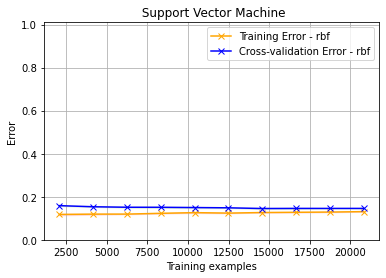

In [27]:
my_learn_curve(title=" Support Vector Machine", 
               estimator=get_census_pipeline_final(), 
               cv=stratified_kfold,
               X=X_c_train, 
               y=y_c_train,  
               label_suffix="rbf", 
               color_=["orange","blue"],
               shape = 'x-'  )


In [30]:
def get_census_pipeline_base():
    liver_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('scaler', StandardScaler()),
                   ("model",   MLPClassifier(solver = "sgd",
                                             random_state = 12, 
                                             ))]
    return Pipeline(steps=liver_steps)

In [ ]:
print(grid_result.best_estimator_.get_params())
print(classification_report(y_c_train, grid_result.best_estimator_.predict(X_c_train) ))
print(classification_report(y_c_test, grid_result.best_estimator_.predict(X_c_test) ))

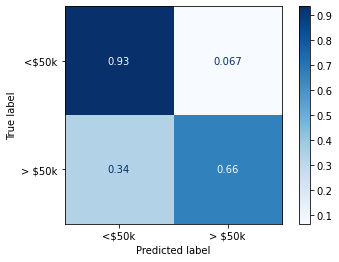

In [29]:
plot_confusion_matrix(estimator=  get_census_pipeline_final().fit(X_c_train, y_c_train),
                      X=X_c_train,
                      y_true= y_c_train  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["<$50k" ,"> $50k"]
                        )

In [35]:
base_c?

In [38]:
base_c = get_census_pipeline_base()
print(average_precision_score(y_c_train, base_c.fit(X_c_train,y_c_train).predict_proba(X_c_train)[:,1]))
print(average_precision_score(y_c_train,get_census_pipeline_final().fit(X_c_train, y_c_train).predict_proba(X_c_train)[:,1]))
print(average_precision_score(y_c_test,get_census_pipeline_final().fit(X_c_train, y_c_train).predict_proba(X_c_test)[:,1]))

0.8145254254606573
0.8096232693462557
0.7755352405370302


In [35]:
#format test data
X_c_test= test_data.drop('income', axis=1)
y_c_test= test_data['income']
print(classification_report(y_c_train, get_census_pipeline_final().fit(X_c_train, y_c_train).predict(X_c_train) ))
print(classification_report(y_c_test, get_census_pipeline_final().fit(X_c_train, y_c_train).predict(X_c_test) ))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     19758
           1       0.76      0.66      0.71      6271

    accuracy                           0.87     26029
   macro avg       0.83      0.80      0.81     26029
weighted avg       0.86      0.87      0.86     26029

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4940
           1       0.72      0.63      0.68      1568

    accuracy                           0.85      6508
   macro avg       0.81      0.78      0.79      6508
weighted avg       0.85      0.85      0.85      6508



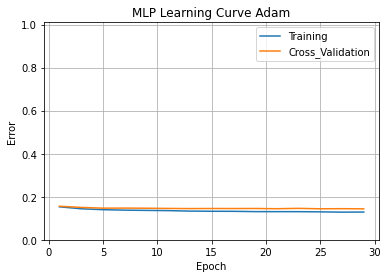

In [63]:
# stratified_kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
# val_train_scores = []
# for i in range (1,30,2):
#     scores = cross_validate(get_census_pipeline_final(i), X_c_train, y_c_train, cv=stratified_kfold,
#                    scoring=('accuracy'),
#                     return_train_score=True)
#     val = 1. - scores['test_score'].mean()
#     training = 1. - scores['train_score'].mean()
#     epoch = i
#     val_train_scores.append([training,val,epoch])
    
pd_val = pd.DataFrame(val_train_scores, columns=["Training", "Cross_Validation","epoch"])
val_plot =pd_val.plot(y=["Training", "Cross_Validation"],x="epoch", title="MLP Learning Curve Adam" )
plt.grid()
plt.ylim(0.0, 1.01)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig("MLP_final_CENSUS_LEARNING_CURVE_adam.pdf")